**If I contract COVID-19, will I die?** 

This is one of our top concerns during the pandemic. Potentially, this information can also help governments and hospitals allocate medical resources to people and places in most urgent need.

In this project, I'm training a classifier to **predict a given patient's probability of death given their age, sex, preconditions, symptoms, and local medical resources (e.g., number of hospital beds and doctors per 10,000 residents)**.

The [Outbreak and Pandemic Preparedness team](https://globalhealth.washington.edu/uw-metacenter-0) at the University of Washington have put together the most complete patient-level dataset and are updating it on a daily basis. However, among the 100,000+ cases in this dataset, only 300+ have known treatment outcomes. Because the available data is limited and likely unrepresentative (e.g., perhaps only "newsworthy" cases have outcome information), predictions should be absolutely taken with a grain of salt. That said, it's useful to have a solid machine learning pipeline in place so we can rapidly update predictions as new data rolls in.

# Data wrangling

In [5]:
%load_ext lab_black

ERROR:root:__call__() missing 1 required positional argument: 'value'
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/lab_black.py", line 218, in format_cell
    formatted_code = _format_code(cell)
  File "/opt/anaconda3/lib/python3.7/site-packages/lab_black.py", line 29, in _format_code
    return format_str(src_contents=code, mode=FileMode())
TypeError: __call__() missing 1 required positional argument: 'value'
ERROR:root:__call__() missing 1 required positional argument: 'value'
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/lab_black.py", line 218, in format_cell
    formatted_code = _format_code(cell)
  File "/opt/anaconda3/lib/python3.7/site-packages/lab_black.py", line 29, in _format_code
    return format_str(src_contents=code, mode=FileMode())
TypeError: __call__() missing 1 required positional argument: 'value'


In [3]:
# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import missingno as msno
import re
import geopandas as gpd
import folium
from statistics import median

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, plot_confusion_matrix
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import shap
import pickle

import warnings

warnings.simplefilter("ignore")

ERROR:root:__call__() missing 1 required positional argument: 'value'
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/lab_black.py", line 218, in format_cell
    formatted_code = _format_code(cell)
  File "/opt/anaconda3/lib/python3.7/site-packages/lab_black.py", line 29, in _format_code
    return format_str(src_contents=code, mode=FileMode())
TypeError: __call__() missing 1 required positional argument: 'value'
ERROR:root:__call__() missing 1 required positional argument: 'value'
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/lab_black.py", line 218, in format_cell
    formatted_code = _format_code(cell)
  File "/opt/anaconda3/lib/python3.7/site-packages/lab_black.py", line 29, in _format_code
    return format_str(src_contents=code, mode=FileMode())
TypeError: __call__() missing 1 required positional argument: 'value'


## Load data
I downloaded the latest data from the Outbreak and Pandemic Preparedness team's [GitHub](https://github.com/beoutbreakprepared/nCoV2019).

In [2]:
# Etra effort to read this file correctly
df = pd.read_csv(
    "latestdata.csv", sep=",", error_bad_lines=False, index_col=False, dtype="unicode",
)
# Rows and columns
df.shape

(128319, 34)

## Exploratory data analysis (EDA)

### Basic information

In [3]:
# Rows and columns
print("This dataset has {} rows and {} columns.\n".format(df.shape[0], df.shape[1]))

# Variables and types
print(df.info())

This dataset has 128319 rows and 34 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128319 entries, 0 to 128318
Data columns (total 34 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   ID                        128319 non-null  object
 1   age                       5049 non-null    object
 2   sex                       5332 non-null    object
 3   city                      57488 non-null   object
 4   province                  114759 non-null  object
 5   country                   128289 non-null  object
 6   wuhan(0)_not_wuhan(1)     64744 non-null   object
 7   latitude                  127218 non-null  object
 8   longitude                 127218 non-null  object
 9   geo_resolution            127218 non-null  object
 10  date_onset_symptoms       1850 non-null    object
 11  date_admission_hospital   961 non-null     object
 12  date_confirmation         127059 non-null  object
 13  symptoms     

All 34 variables are stored as strings, which need to be converted into numerics before model training.

### Missing values

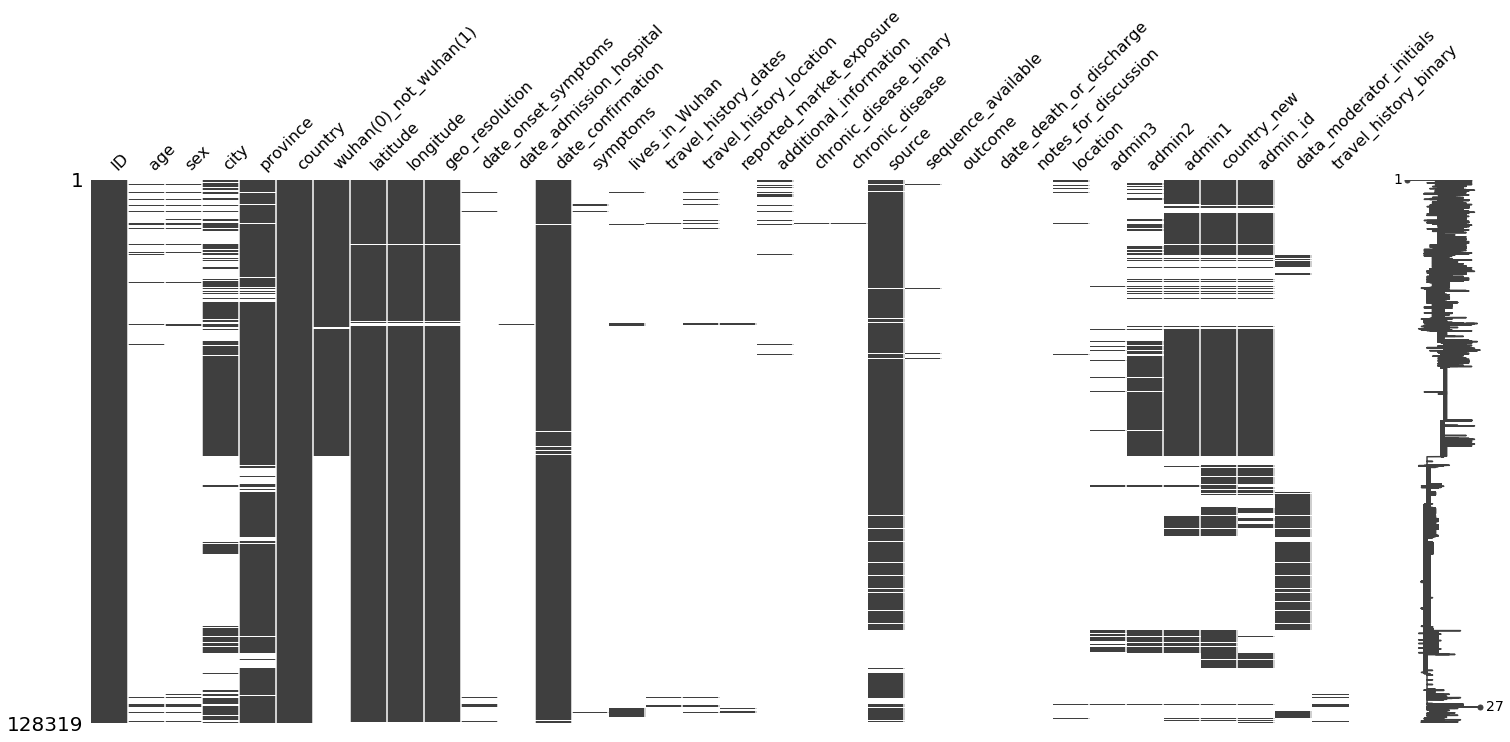

In [4]:
msno.matrix(df)

Most demographic information (e.g., age, sex) and clinical features (e.g., symptoms, outcomes) are missing. Rather than imputing these missing values, it's safer to only use patients whose outcomes are known.

### Age distribution

In [5]:
# Show unique values of age
df["age"].unique()

array(['50-59', nan, '60-69', '30-39', '30', '44', '65', '8-68', '21-72',
       '26', '45', '36', '43', '70', '52', '66', '27', '17', '51', '68',
       '53', '35', '28', '58', '33', '31', '50', '24', '88', '29', '21',
       '78', '60', '63', '37', '32', '49', '71', '20-29', '18-99', '47',
       '41', '39', '42', '38', '7', '40-49', '82', '61', '64', '34-66',
       '62', '40-89', '80-89', '55', '0.25', '13-19', '69', '16', '8',
       '10', '25', '34', '55-74', '75-', '70-79', '79', '35-54', '55-',
       '95', '40', '54', '40-50', '46', '48', '57', '56', '60-60',
       '80-80', '73', '0-18', '77', '67', '18-', '0-6', '0-10', '22',
       '74', '10-19', '83', '96', '76', '20', '19', '1.75', '9', '75',
       '18-65', '1', '54-56', '0.6666666667', '74-76', '27-29', '80',
       '18', '72', '4', '59', '15', '61-80', '23', '65-99', '81', '90-99',
       '50-69', '50-60', '92', '85', '91', '87', '14', '12', '19-65',
       '70-70', '60-70', '2', '30-70', '20-70', '20-69', '16-17', '94

Many patients' age is shown as a range (e.g., "20-29"). For those patients, we can replace age ranges with medians.

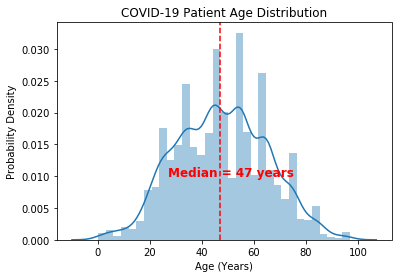

In [6]:
# Replace age ranges with medians
df["age"] = df["age"].apply(
    lambda x: median([float(i) for i in str(x).split(sep="-") if i])
)

# Plot age distribution
sns.distplot(df["age"].dropna())
plt.axvline(df["age"].median(), color="r", linestyle="--")
plt.title("COVID-19 Patient Age Distribution")
plt.xlabel("Age (Years)")
plt.ylabel("Probability Density")
plt.text(
    df["age"].median() - 20,
    0.010,
    "Median = 47 years",
    horizontalalignment="left",
    size="large",
    color="red",
    weight="semibold",
)
plt.show()

According to [Our World in Data](https://ourworldindata.org/age-structure), the median age of the global population is 29.6 years as of 2019. With a median age of 48 years, COVID-19 patients in the current dataset are considerably older than the average population.

### Country distribution

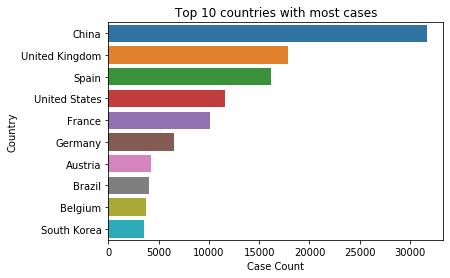

In [7]:
# Generate case count by country
country_counts = pd.DataFrame(df["country"].value_counts()).reset_index()
country_counts.columns = ["country", "count"]

# Plot countries with top 10 most casees
sns.barplot(x="count", y="country", data=country_counts.head(10))
plt.title("Top 10 countries with most cases")
plt.xlabel("Case Count")
plt.ylabel("Country")
plt.show()

Apparently, the information is quite dated as we now know that case counts in the United States and Italy have surpassed that in China. To see the geographical distribution of case count by country, I generated a choropleth map below. (If you want to see how outbreaks spread across geolocations over time, check out this [animated visualization](https://www.healthmap.org/covid-19/) created by the HealthMap team.)

In [8]:
# JSON file of world map
world_map = "world-countries.json"

# Convert country name to 3-digit code
look_up = gpd.read_file(world_map)[["id", "name"]]
code_counts = country_counts.set_index("country").join(look_up.set_index("name"))

In [9]:
# Which countries failed to convert?
code_counts[code_counts.isnull().any(axis=1)]

count   id
country                                     
United States                     11640  NaN
Singapore                           153  NaN
Bahrain                              34  NaN
Malta                                29  NaN
Reunion                               9  NaN
San Marino                            2  NaN
Maldives                              2  NaN
Saint Vincent and the Grenadines      1  NaN
Andorra                               1  NaN
North Macedonia                       1  NaN
Virgin Islands, U.S.                  1  NaN
Liechtenstein                         1  NaN
Gibraltar                             1  NaN
Serbia                                1  NaN

In [10]:
# Convert them manulaly
code_counts.loc["United States", "id"] = "USA"
code_counts.loc["Singapore", "id"] = "SGP"
code_counts.loc["Bahrain", "id"] = "BHR"
code_counts.loc["Reunion", "id"] = "REU"
code_counts.loc["Maldives", "id"] = "MDV"
code_counts.loc["San Marino", "id"] = "SMR"
code_counts.loc["North Macedonia", "id"] = "MKD"
code_counts.loc["Gibraltar", "id"] = "GIB"
code_counts.loc["Liechtenstein", "id"] = "LIE"
code_counts.loc["Virgin Islands, U.S.", "id"] = "VIR"
code_counts.loc["Malta", "id"] = "MLT"
code_counts.loc["Saint Vincent and the Grenadines", "id"] = "VCT"
code_counts.loc["Andorra", "id"] = "AND"
code_counts.loc["Serbia", "id"] = "SRB"

In [11]:
# Create bins for the legend
bins = [1, 100, 1000, 5000, 10000, 45000]

# Careate an empty map
map = folium.Map(location=[0, 0], zoom_start=1.5)  # Default location is good

# Add counts to map
folium.Choropleth(
    geo_data=world_map,
    name="choropleth",
    data=code_counts,
    columns=["id", "count"],
    key_on="feature.id",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="COVID-19 case count by country",
    bins=bins,
).add_to(map)

# Render new map
folium.LayerControl().add_to(map)
map

East Asia, Southern Europe, and North America have taken by far the hardest hit compared to elsewhere in the world. 

## Feature engineering
Since the main application of my project is to predict mortality risk for new cases, it make little sense to include features that won't occur again (e.g., date of confirmation) or don't have a stable relationship with the outcome (e.g., location). For instance, two months ago, Wuhan was the most dangerous city on Earth but now it's one of the safest. Dropping date and location features may hurt model performance for now but increase generalizability for the future. 

Locations, however, do contain generalizable information such as medical resources (e.g., hospital beds and health professionals per capita). We can use locations to extract medical resource information and then use that as predictors. Other generalizable features include patients' age, sex, preconditions, and symptoms.

### Target variable
The target variable is each patient's treatment outcome "is_dead" (yes: 1, no: 0).

In [12]:
# Only select patients with known outcome
df_known = df.dropna(subset=["outcome"])

# Value count by outcome
df_known["outcome"].value_counts()

discharge                                                                   84
stable                                                                      78
died                                                                        59
discharged                                                                  56
death                                                                       19
recovered                                                                    5
released from quarantine                                                     3
Discharged                                                                   2
Discharged from hospital                                                     2
critical condition, intubated as of 14.02.2020                               1
treated in an intensive care unit (14.02.2020)                               1
Symptoms only improved with cough. Currently hospitalized for follow-up.     1
recovering at home 03.03.2020                       

Since my purpose is predict mortality risk, I converted outcomes to binary: 1 (dead) vs. 0 (not dead).

In [13]:
# New binary outcome: "is_dead"
df_known.loc[:, "is_dead"] = df_known["outcome"].apply(
    lambda x: 1 if x in ["died", "death", "dead"] else 0
)

### Explanatory variables

In [14]:
# Select relevant variables only
to_keep = [
    "age",
    "sex",
    "symptoms",
    "country",
    "chronic_disease",
    "chronic_disease_binary",
    "is_dead",
]

df_known = df_known[to_keep]

#### 1. Medical resources by country
The patient dataset has no information on medical resources in each country. I pulled country-level data on [hospital beds per 10,000 residents](https://apps.who.int/gho/data/view.main.HS07v) and [medical doctors per 10,000 residents](https://apps.who.int/gho/data/view.main.HWFMEDv) from the World Health Organization (WHO).

In [15]:
# Load data from WHO
hospital = pd.read_csv("hospital_beds.csv")
doctors = pd.read_csv("doctors.csv")

# Select most recent data for each country
hospital_latest = hospital.loc[hospital.groupby("Country")["Year"].idxmax()]
doctors_latest = doctors.loc[doctors.groupby("Country")["Year"].idxmax()]

# Rename columns
new_cols1 = {
    "Country": "country",
    "Year": "year",
    "Hospital beds (per 10 000 population)": "beds_per_10k",
}

new_cols2 = {
    "Country": "country",
    "Year": "year",
    "Medical doctors (per 10 000 population)": "docs_per_10k",
}

hospital_latest.rename(columns=new_cols1, inplace=True)
doctors_latest.rename(columns=new_cols2, inplace=True)

# Get rid of parenthesis area in country names
hospital_latest["country"] = hospital_latest["country"].apply(
    lambda x: re.sub(r" ?\([^)]+\)", "", x)
)

doctors_latest["country"] = doctors_latest["country"].apply(
    lambda x: re.sub(r" ?\([^)]+\)", "", x)
)

# OUTER JOIN bed and doctor data
medical = hospital_latest.merge(doctors_latest, on="country", how="outer")
medical.drop(["year_x", "year_y"], axis=1, inplace=True)

# LEFT JOIN medical resource data with patient data
df_known = df_known.merge(medical, on="country", how="left")

#### 2. Demographic information

In [16]:
# Replace "female" with 1 and "male" with 0
df_known["sex"].replace({"female": 1, "male": 0}, inplace=True)

#### 3. Chronic diseases and symptoms
Many patients have more than one chronic disease or symptom. I counted the frequency of each disease and symptom and created binary variables (yes: 1, no: 0) for the most frequent ones.

In [17]:
# Convert "chronic_disease_binary" to numerics
df_known["chronic_disease_binary"] = pd.to_numeric(
    df_known["chronic_disease_binary"], errors="coerce"
)

In [18]:
# Put all dieases in a list
diseases = [disease.split(",") for disease in df_known["chronic_disease"].dropna()]

# Flatten the list
diseases = [item for sublist in diseases for item in sublist]
diseases = " ".join(diseases).split()

# Count frequencies (show top 5)
pd.Series(diseases).str.strip().value_counts().head()

hypertension    18
diabetes        15
disease          8
coronary         7
chronic          5
dtype: int64

By far the most common chronic diseases are hypertension, diabetes, and coronary heart disease.

In [19]:
# One-hot encode hypertension and diabetes
diseases_top2 = ["hypertension", "diabetes"]

for disease in diseases_top2:
    df_known[disease] = df_known["chronic_disease"].apply(
        lambda x: 1 if disease in str(x) else 0
    )

# One-hot encode coronary heart disease
df_known["heart"] = df_known["chronic_disease"].apply(
    lambda x: 1 if "heart" in str(x) or "coronary" in str(x) else 0
)

Let's do the same for symptoms.

In [20]:
# Put all symptoms in a list
symptoms = [symptom.split(",") for symptom in df_known["symptoms"].dropna()]

# Flatten the list
symptoms = [item for sublist in symptoms for item in sublist]

# Count frequencies (show top 5)
pd.Series(symptoms).str.strip().value_counts().head()

fever          63
cough          41
fatigue         9
sore throat     8
headache        5
dtype: int64

The most frequent symptoms experienced by COVID-19 patients are fever, cough, fatigue, and sore throat.

In [21]:
# One-hot encode top 4 symptoms
symptoms_top4 = pd.Series(symptoms).str.strip().value_counts().head(4).index.tolist()

for symptom in symptoms_top4:
    df_known[symptom] = df_known["symptoms"].apply(
        lambda x: 1 if symptom in str(x) else 0
    )

Finally, I dropped columns that will no longer be needed.

In [22]:
# Column list
to_drop = ["country", "symptoms", "chronic_disease"]

# Drop from dataframe
df_known.drop(to_drop, axis=1, inplace=True)

### Missing values

In [23]:
# Function: Display columns with missing values
def check_missing(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing = pd.concat([total, percent], axis=1, keys=["total", "percent"])
    missing = missing.loc[missing["total"] > 0, :]
    return missing

In [24]:
# Check missing values in each column
check_missing(df_known)

total   percent
chronic_disease_binary    283  0.898413
sex                        65  0.206349
beds_per_10k               47  0.149206
docs_per_10k               46  0.146032
age                        28  0.088889

Even the cleaned dataset has a large proportion of data missing. Rather than imputing data or dropping cases with missing values, I prefer to use algorithms (e.g., tree-based methods such as XGBoost) that tolerate missing values.

### Test/train split
Before examining how key features relate to the outcome, I split the whole dataset into 20% test and 80% train.

In [25]:
# Target variable: "is_dead"
y = df_known["is_dead"]

# Explanatory variables: all the rest
X = df_known.loc[:, df_known.columns != "is_dead"]

# Create training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=465
)

## More EDA

### Univariate analysis

#### 1. Outcome

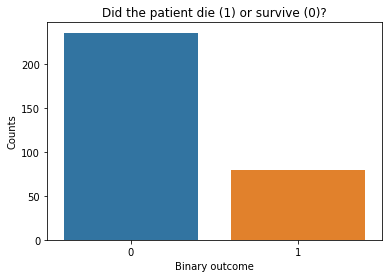

In [26]:
# Plot outcomes
sns.countplot(df_known["is_dead"])
plt.xlabel("Binary outcome")
plt.ylabel("Counts")
plt.title("Did the patient die (1) or survive (0)?")
plt.show()

More patients survived (> 200) than died (< 100). To improve model performance, we can either oversample the minority class or undersample the majority class to get rid of class imbalance. However, most resampling techniques such as SMOTE can't tolerate missing data. Because large amounts of data is missing, I don't want to drop all cases with any missing data (lose too much power) or impute all the missing values (alter distributions too much). Because the class imbalance here is not very extreme, model performance shouldn't suffer too much without resampling.

#### 2. Demographic information

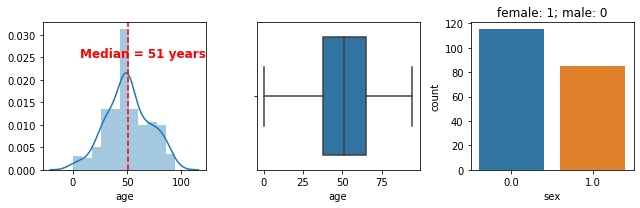

In [27]:
plt.figure(figsize=(9, 3))

# Age distribution
plt.subplot(1, 3, 1)
ax1 = sns.distplot(X_train["age"].dropna())
ax1.axvline(X_train["age"].median(), color="r", linestyle="--")
ax1.text(
    df["age"].median() - 40,
    0.025,
    "Median = 51 years",
    horizontalalignment="left",
    size="large",
    color="red",
    weight="semibold",
)

# Age outliers
plt.subplot(1, 3, 2)
ax2 = sns.boxplot(X_train["age"].dropna())

# Count by sex
plt.subplot(1, 3, 3)
ax3 = sns.countplot(X_train["sex"].dropna(), orient="v")
ax3.set_title("female: 1; male: 0")

plt.tight_layout()
plt.show()

Like the age distribution of all patients, the median age (51 years) in the training data is also considerably older than the average population. The box plot above doesn't show any outliers. In the training data, more male patients died than female patients.

#### 3. Medical resources

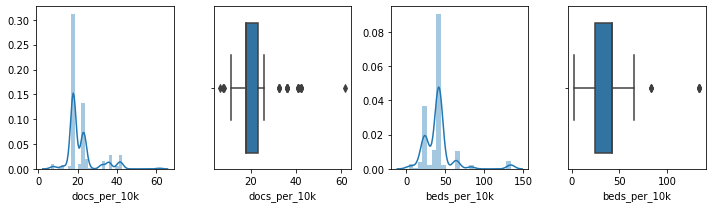

In [28]:
plt.figure(figsize=(10, 3))

# Distribution of doctors per 10,000
plt.subplot(1, 4, 1)
sns.distplot(X_train["docs_per_10k"].dropna())

# Outliers in doctors per 10,000
plt.subplot(1, 4, 2)
sns.boxplot(X_train["docs_per_10k"].dropna())

# Distribution of beds per 10,000
plt.subplot(1, 4, 3)
sns.distplot(X_train["beds_per_10k"].dropna())

# Outliers in beds per 10,000
plt.subplot(1, 4, 4)
sns.boxplot(X_train["beds_per_10k"].dropna())

plt.tight_layout()
plt.show()

Neither doctors per 10,000 or beds per 10,000 are normally distributed. Both have outliers. It's unlikely that data from WHO have measurement errors, so these outliers are genuine observations that I prefer to keep.

#### 4. Clinical features

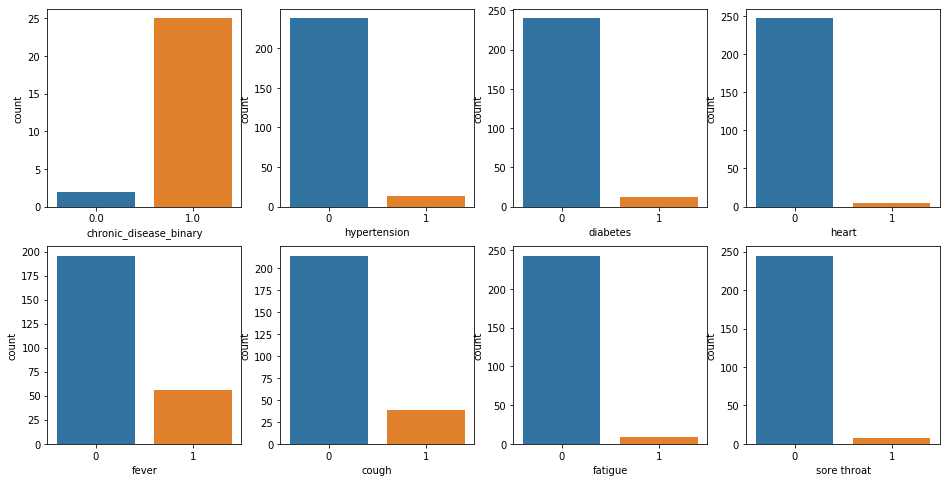

In [29]:
# List of clinical features (preconditions and symptoms)
clinical_features = [
    "chronic_disease_binary",
    "hypertension",
    "diabetes",
    "heart",
    "fever",
    "cough",
    "fatigue",
    "sore throat",
]

# Plot outcome by each feature
plt.figure(figsize=(16, 8))

i = 1
for col in clinical_features:
    plt.subplot(2, 4, i)
    sns.countplot(X_train[col].dropna())
    i += 1

plt.tight_layout
plt.show()

For each precondition or symptom, only a minority of patients had it.

### Bivariate analysis

In [30]:
# Concatenate features with outcome
df_train = pd.concat([X_train, y_train], axis=1)

#### 1. Demographics and outcome

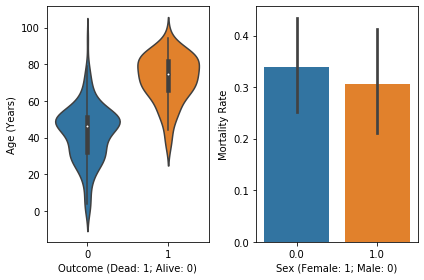

Mean age of the diseased: 71.84 years; mean age of those who survived: 42.52 years.


In [31]:
f, axes = plt.subplots(1, 2)

# Age × outcome
sns.violinplot(x="is_dead", y="age", data=df_train, ax=axes[0])
axes[0].set_xlabel("Outcome (Dead: 1; Alive: 0)")
axes[0].set_ylabel("Age (Years)")

# Sex × outcome
sns.barplot(x="sex", y="is_dead", data=df_train, ax=axes[1])
axes[1].set_xlabel("Sex (Female: 1; Male: 0)")
axes[1].set_ylabel("Mortality Rate")

plt.tight_layout()
plt.show()

print(
    "Mean age of the diseased: {} years; mean age of those who survived: {} years.".format(
        round(df_train[df_train["is_dead"] == 1]["age"].mean(), 2),
        round(df_train[df_train["is_dead"] == 0]["age"].mean(), 2),
    )
)

Those who died were much older than those who survived. Very few deceased were under the age of 40. Female patients seem to have a lower mortality rate than male patients.

#### 2. Medical resources and outcome

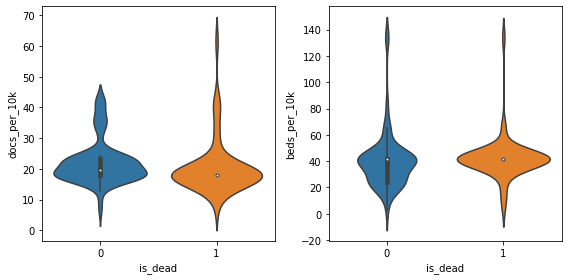

In [32]:
plt.figure(figsize=(8, 4))

# Doctors per 10,000 × outcome
plt.subplot(1, 2, 1)
sns.violinplot(x="is_dead", y="docs_per_10k", data=df_train)

# Beds per 10,000 × outcome
plt.subplot(1, 2, 2)
sns.violinplot(x="is_dead", y="beds_per_10k", data=df_train)

plt.tight_layout()
plt.show()

#### 3. Clinical features and outcome

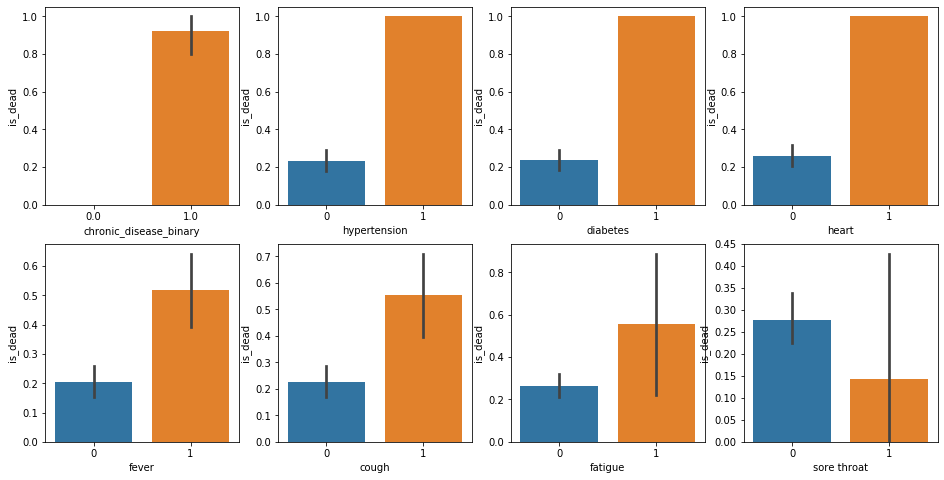

In [33]:
# Plot outcome by each feature
plt.figure(figsize=(16, 8))

i = 1
for col in clinical_features:
    plt.subplot(2, 4, i)
    sns.barplot(x=col, y="is_dead", data=df_train)
    i += 1

plt.tight_layout
plt.show()

Apart from a sore throat, having any of the symptoms or predictions predicts higher mortality risk.

#### 4. Correlation matrix
Finally, we can use the correlation matrix to see how strongly each feature is related to the outcome.

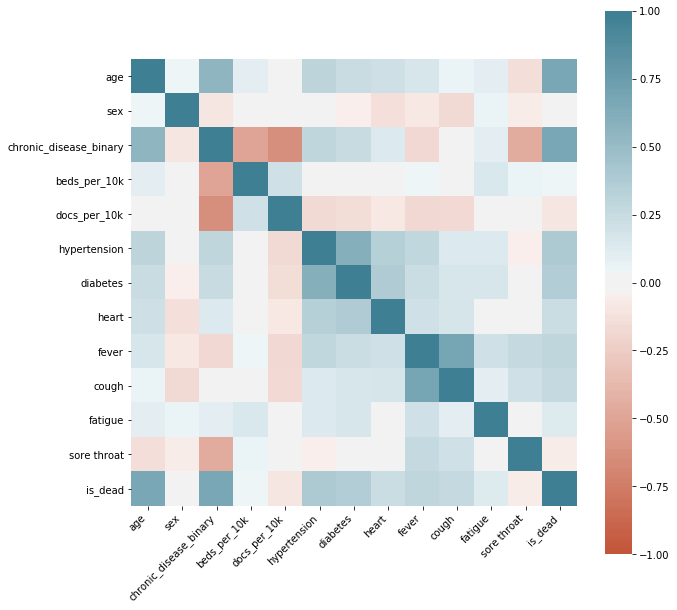

In [34]:
# Correlation among all variables
corr = df_train.corr()

# Plot Pearson correaltion coefficients on a heat map
plt.figure(figsize=(10, 10))

ax = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")

plt.show()

Age is most strongly correlated with the outcome. Most preconditions and symptoms are somewhat positively correlated. The number of doctors per 10,000 residents is negatively correlated with mortality risk.

## Feature scaling
To make sure features are on the same scale, let's scale age, beds per 10,000, and doctors per 10,000. Because there are outliers, I used `RobustScaler()` instead of `StandardScaler()` or `MinMaxScaler()`.


In [35]:
# Create RobustScaler objects
age_scaler = RobustScaler()
beds_scaler = RobustScaler()
docs_scaler = RobustScaler()

# Transform age
X_train["age_scaled"] = age_scaler.fit_transform(X_train[["age"]].values.astype(float))
X_test["age_scaled"] = age_scaler.fit_transform(X_test[["age"]].values.astype(float))

# Drop original age
X_train.drop("age", axis=1, inplace=True)
X_test.drop("age", axis=1, inplace=True)

# Transform beds per 10,000
X_train["beds_per_10k"] = beds_scaler.fit_transform(
    X_train[["beds_per_10k"]].values.astype(float)
)

X_test["beds_per_10k"] = beds_scaler.fit_transform(
    X_test[["beds_per_10k"]].values.astype(float)
)

# Transform doctors per 10,000
X_train["docs_per_10k"] = docs_scaler.fit_transform(
    X_train[["docs_per_10k"]].values.astype(float)
)

X_test["docs_per_10k"] = docs_scaler.fit_transform(
    X_test[["docs_per_10k"]].values.astype(float)
)

# Classify patients
Finally, I'm using features I just engineered to **classify** each patient's outcome. When choosing the right classifier, I'm most concerned with the missingness and the sparsity of observations (only 248 in train and 62 in test) in my data. To address these concerns, I opted to use XGBoost. First of all, XGBoost automatically infers missing values based on existing patterns so I don't have to drop all cases with missing values or impute values in a way that alters patterns in the data. It's also nice that XGBoost has several built-in measures for preventing overfitting (e.g., L1 and L2 penalties, automatic cross-validation), which is important for my small dataset.

## Build an XGBoost classifier
XGBoost has more hyper-parameters than most models. To achieve good performance, it's crucial to find the optimal values for these hyper-parameters. I tried both Bayesian optimization (implemented by `hyperopt`) and traditional grid search and the latter achieved better results. Since grid search can be computationally costly, rather than tuning all hyper-parameters at once, I tuned a couple of parameters at a time.

In [36]:
# Function: Find best estimator
def param_tuning(estimator, parameters, data, target):

    # Set up grid search
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=parameters,
        scoring="roc_auc",
        n_jobs=10,
        cv=10,
        verbose=True,
    )

    # Train on training data
    grid_search.fit(data, target)

    # Output best estimator
    return grid_search.best_estimator_

# Function: Train classifier and evaluate performance
def model_fit(model, data_train, data_test, target_train, target_test):

    # Fit on training data
    model.fit(data_train, target_train)

    # Cross validate on training data
    scores = cross_val_score(model, data_train, target_train, cv=10, scoring="roc_auc")
    print("AUC in each fold: {}; mean: {}\n".format(scores, scores.mean()))

    # Predict outcome for testing data
    y_pred = model.predict(data_test)

    # Display performance metrics
    xgb_eval = classification_report(target_test, y_pred, labels=[0, 1])
    print(xgb_eval)

    # Confusion matrix
    plot_confusion_matrix(
        model,
        data_test,
        target_test,
        display_labels=["survived", "dead"],
        cmap=plt.cm.Blues,
        normalize=None,
    )
    plt.title("Confusion matrix")

### 1. Default model

AUC in each fold: [1.         0.93233083 0.89473684 0.91269841 0.98412698 0.94444444
 0.84920635 0.91666667 0.96031746 0.91269841]; mean: 0.9307226399331663

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        53
           1       0.59      1.00      0.74        10

    accuracy                           0.89        63
   macro avg       0.79      0.93      0.84        63
weighted avg       0.93      0.89      0.90        63



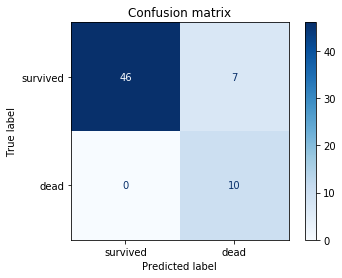

In [37]:
xgb_base = XGBClassifier(learning_rate=0.1, early_stopping_rounds=10)
model_fit(xgb_base, X_train, X_test, y_train, y_test)

In [38]:
### 2. Tune `max_depth` and `min_child_weight`

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed:    4.5s finished


AUC in each fold: [1.         0.96992481 0.88596491 0.92857143 0.98412698 0.96031746
 0.86507937 0.94047619 0.96825397 0.8968254 ]; mean: 0.9399540517961571

              precision    recall  f1-score   support

           0       0.98      0.89      0.93        53
           1       0.60      0.90      0.72        10

    accuracy                           0.89        63
   macro avg       0.79      0.89      0.83        63
weighted avg       0.92      0.89      0.90        63



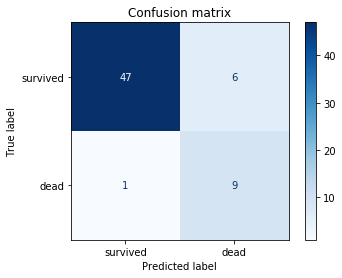

In [39]:
param_step1 = {"max_depth": range(2, 10, 1), "min_child_weight": range(1, 6, 2)}
xgb_step1 = param_tuning(xgb_base, param_step1, X_train, y_train)
model_fit(xgb_step1, X_train, X_test, y_train, y_test)

### 3. Tune `gamma`

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done 840 tasks      | elapsed:    8.4s
[Parallel(n_jobs=10)]: Done 1540 tasks      | elapsed:   15.2s
[Parallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:   20.7s finished


AUC in each fold: [1.         0.91729323 0.87719298 0.90873016 1.         0.93650794
 0.88095238 0.97222222 0.98412698 0.96031746]; mean: 0.9437343358395991

              precision    recall  f1-score   support

           0       0.98      0.89      0.93        53
           1       0.60      0.90      0.72        10

    accuracy                           0.89        63
   macro avg       0.79      0.89      0.83        63
weighted avg       0.92      0.89      0.90        63



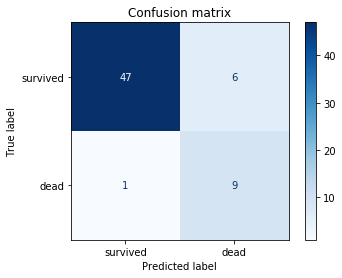

In [40]:
param_step2 = {"gamma": np.arange(0.0, 10.0, 0.05)}
xgb_step2 = param_tuning(xgb_step1, param_step2, X_train, y_train)
model_fit(xgb_step2, X_train, X_test, y_train, y_test)

### 4. Tune `subsample` and `colsample_bytree`

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 250 out of 250 | elapsed:    2.5s finished


AUC in each fold: [0.9924812  0.89473684 0.92982456 0.92857143 0.98412698 0.96031746
 0.84126984 0.96428571 0.98412698 0.97619048]; mean: 0.945593149540518

              precision    recall  f1-score   support

           0       0.96      0.89      0.92        53
           1       0.57      0.80      0.67        10

    accuracy                           0.87        63
   macro avg       0.77      0.84      0.79        63
weighted avg       0.90      0.87      0.88        63



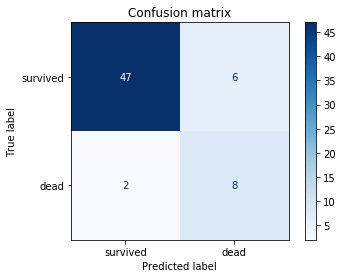

In [41]:
param_step3 = {
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9],
}
xgb_step3 = param_tuning(xgb_step2, param_step3, X_train, y_train)
model_fit(xgb_step3, X_train, X_test, y_train, y_test)

### 5. Tune `reg_alpha`

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  70 out of  70 | elapsed:    0.6s finished


AUC in each fold: [0.9924812  0.89473684 0.92982456 0.92857143 0.98412698 0.96031746
 0.84126984 0.96428571 0.98412698 0.97619048]; mean: 0.945593149540518

              precision    recall  f1-score   support

           0       0.96      0.89      0.92        53
           1       0.57      0.80      0.67        10

    accuracy                           0.87        63
   macro avg       0.77      0.84      0.79        63
weighted avg       0.90      0.87      0.88        63



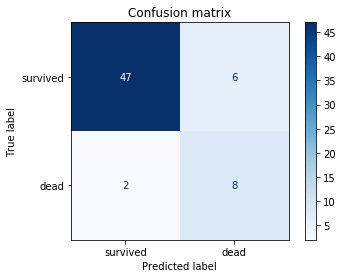

In [42]:
param_step4 = {"reg_alpha": [1e-5, 1e-2, 0.1, 0.5, 1, 5, 100]}
xgb_step4 = param_tuning(xgb_step3, param_step4, X_train, y_train)
model_fit(xgb_step4, X_train, X_test, y_train, y_test)

### 4. Tune `learning_rate`

Fitting 10 folds for each of 990 candidates, totalling 9900 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 840 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done 1540 tasks      | elapsed:   11.4s
[Parallel(n_jobs=10)]: Done 2440 tasks      | elapsed:   17.2s
[Parallel(n_jobs=10)]: Done 3540 tasks      | elapsed:   25.3s
[Parallel(n_jobs=10)]: Done 4840 tasks      | elapsed:   33.8s
[Parallel(n_jobs=10)]: Done 6340 tasks      | elapsed:   44.2s
[Parallel(n_jobs=10)]: Done 8040 tasks      | elapsed:   55.3s
[Parallel(n_jobs=10)]: Done 9900 out of 9900 | elapsed:  1.1min finished


AUC in each fold: [0.98496241 0.90225564 0.92982456 0.93650794 1.         0.96031746
 0.85714286 0.96428571 0.98412698 0.97619048]; mean: 0.9495614035087719

              precision    recall  f1-score   support

           0       0.96      0.89      0.92        53
           1       0.57      0.80      0.67        10

    accuracy                           0.87        63
   macro avg       0.77      0.84      0.79        63
weighted avg       0.90      0.87      0.88        63



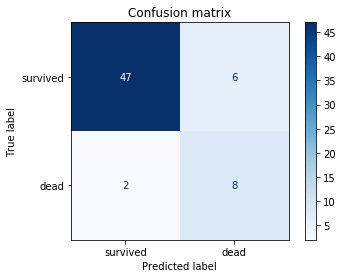

In [43]:
param_step5 = {"learning_rate": np.arange(0.001, 0.1, 0.0001)}
xgb_step5 = param_tuning(xgb_step4, param_step5, X_train, y_train)
model_fit(xgb_step5, X_train, X_test, y_train, y_test)

The best model was the second one.

In [44]:
xgb_best = xgb_step2

## Feature importances
While the meat of this project is to predict mortality risk of patients, it's nice to know which features contribute the most to our predictions. In recent years, explainable AI/ML researchers have proposed many methods for getting **accurate** and **consistent** feature importances out of a "black box" model. One such method is called [SHAP](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27) ("SHapley Additive exPlanations"), which uses Shapley values to allocate credit to features (see this [NeurIPS paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) for details).

In [45]:
shap.initjs()
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

Not only does SHAP tell us which features are most important, it also shows us the direction of influence. The most influential feature is age: The older a patient, the higher the risk. The second most influential feature is doctors per 10,000 residents. However, it doesn't have a linear relationship with mortality risk: When the number is very low, mortality risk is high; however, countries with many doctors per 10,000 seemed to be more "dangerous" than those with a middling number. My theory is that countries with most medical resources are also the most popular destinations with the most cases, which complicates the relationship between medical resources and patient outcomes.

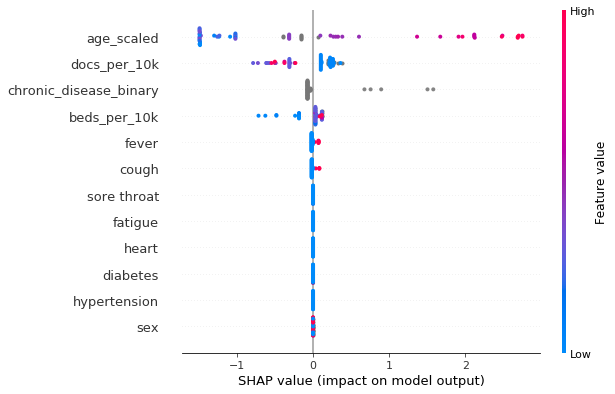

In [46]:
shap.summary_plot(shap_values, X_test)

## Retrain on full dataset
Since we only have a few hundred cases, before using the classifier to make new predictions, let's train it on the full set of data. Like before, we can cross validate the new model and look at feature importances.

In [47]:
# Scale age, docs per 10,000, and beds per 10,000
X["age_scaled"] = age_scaler.fit_transform(X[["age"]].values.astype(float))
X["docs_per_10k"] = docs_scaler.fit_transform(X[["docs_per_10k"]].values.astype(float))
X["beds_per_10k"] = beds_scaler.fit_transform(X[["beds_per_10k"]].values.astype(float))

# Drop original age
X.drop("age", axis=1, inplace=True)

In [48]:
# Retrain on full dataste
xgb_best.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, early_stopping_rounds=10,
              gamma=3.8000000000000003, learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [49]:
# Cross validation
y_pred_all = xgb_best.predict(X)
xgb_eval_all = classification_report(y, y_pred_all, labels=[0, 1])
print(xgb_eval_all)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       236
           1       0.85      0.80      0.82        79

    accuracy                           0.91       315
   macro avg       0.89      0.88      0.88       315
weighted avg       0.91      0.91      0.91       315



Text(0.5, 1.0, 'Confusion matrix')

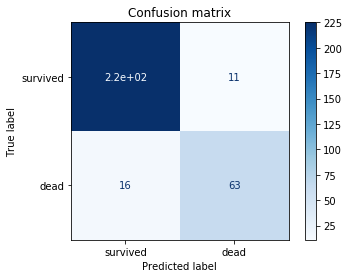

In [50]:
# Confusion matrix
plot_confusion_matrix(
    xgb_best,
    X,
    y,
    display_labels=["survived", "dead"],
    cmap=plt.cm.Blues,
    normalize=None,
)
plt.title("Confusion matrix")

In [51]:
# SHAP
shap.initjs()
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

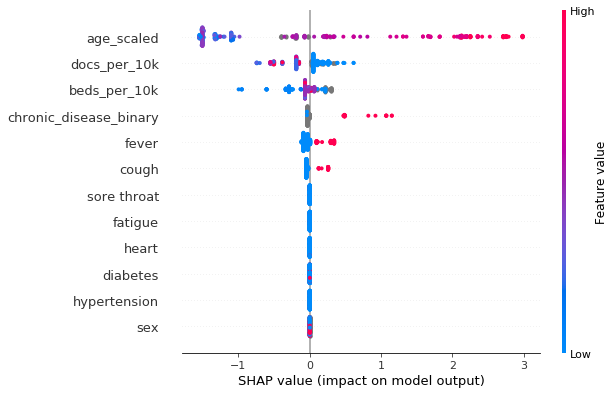

In [52]:
shap.summary_plot(shap_values, X)

## Pickle data and models

In [53]:
# Save models
with open("covid19_risk_xgboost.pkl", "wb") as file:
    pickle.dump(xgb_best, file)

with open("age_scaler.pkl", "wb") as file:
    pickle.dump(age_scaler, file)

with open("docs_scaler.pkl", "wb") as file:
    pickle.dump(docs_scaler, file)

with open("beds_scaler.pkl", "wb") as file:
    pickle.dump(beds_scaler, file)

# Save medical data
with open("medical.pkl", "wb") as file:
    pickle.dump(medical, file)

## Predict your risk

### New input

In [54]:
# Function: Take patient info
def patient_info():

    # Demographic info
    age = input("What's your age?")
    sex = input("What's your biological sex? (female: 1, male: 0)")
    country = input("Which country do you live in?")
    docs_per_10k = medical.loc[
        medical["country"].str.contains(country), "docs_per_10k"
    ].item()
    beds_per_10k = medical.loc[
        medical["country"].str.contains(country), "beds_per_10k"
    ].item()

    # Pre-conditions
    preconition = input("Any chronic dieases that you know of? (yes: 1, no: 0)")
    hypertension = input("Do you have hypertension? (yes: 1, no: 0)")
    diabetes = input("Do you have diabetes? (yes: 1, no: 0)")
    heart = input("Do you have heart diseases? (yes: 1, no: 0)")

    # Symptoms
    fever = input("Do you have fever? (yes: 1, no: 0)")
    cough = input("Are you coughing? (yes: 1, no: 0)")
    fatigue = input("Do you feel fatigue? (yes: 1, no: 0)")
    sore_throat = input("Do you have a sore throat? (yes: 1 , no:0)")

    # Save results in a list
    return {
        "sex": int(sex),
        "chronic_disease_binary": int(preconition),
        "beds_per_10k": float(beds_scaler.transform([[beds_per_10k]])),
        "docs_per_10k": float(docs_scaler.transform([[docs_per_10k]])),
        "hypertension": int(hypertension),
        "diabetes": int(diabetes),
        "heart": int(heart),
        "fever": int(fever),
        "cough": int(cough),
        "fatigue": int(fatigue),
        "sore throat": int(sore_throat),
        "age_scaled": float(age_scaler.transform([[age]])),
    }


# Function: Output risk
def risk_predictor():

    # Get patient info
    new_case = patient_info()

    # Convert to useable format
    new_case = pd.DataFrame(new_case, index=[0])

    # Make prediction
    new_prediction = xgb_best.predict_proba(new_case)

    # Print result
    print(
        "Once contracted COVID-19, your mortality risk is {}%.".format(
            round(new_prediction.tolist()[0][1] * 100, 2)
        )
    )

### Try it yourself!
Answer a few questions to predict your own risk!

In [56]:
risk_predictor()

What's your age? 25
What's your biological sex? (female: 1, male: 0) 0
Which country do you live in? United States
Any chronic dieases that you know of? (yes: 1, no: 0) 0
Do you have hypertension? (yes: 1, no: 0) 0
Do you have diabetes? (yes: 1, no: 0) 0
Do you have heart diseases? (yes: 1, no: 0) 0
Do you have fever? (yes: 1, no: 0) 0
Are you coughing? (yes: 1, no: 0) 0
Do you feel fatigue? (yes: 1, no: 0) 0
Do you have a sore throat? (yes: 1 , no:0) 0


Once contracted COVID-19, your mortality risk is 4.25%.
